In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import interpolate as interp
from scipy import integrate

import ase
from ase.calculators import lj
from ase import build

from ase.md.verlet import VelocityVerlet
from ase.md.nvtberendsen import NVTBerendsen
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase import units
from ase.io.trajectory import Trajectory

import atombond



In [2]:
import importlib
importlib.reload(atombond)

<module 'atombond' from 'C:\\Users\\AJoiner\\Documents\\GitHub\\Atomic-Bonding\\atombond.py'>

In [3]:
%matplotlib inline

In [4]:
traj_filenm = 'lj_rho0.82_T600_N500.traj'
traj = Trajectory(traj_filenm)

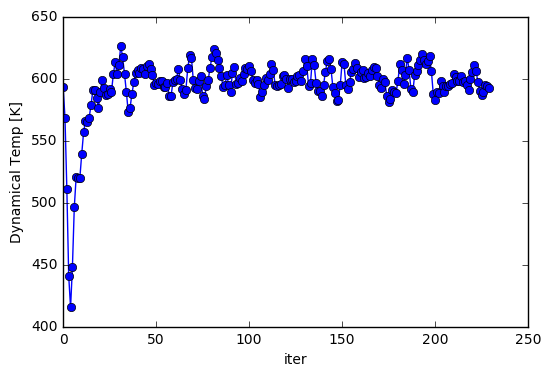

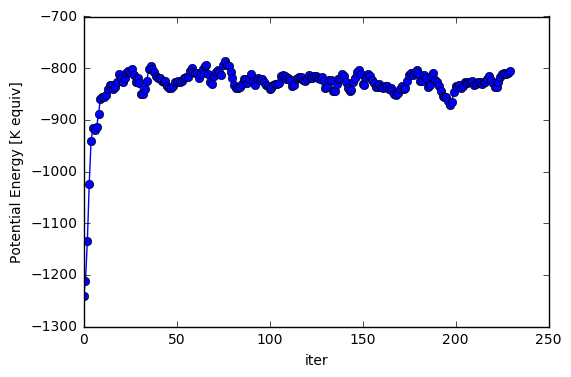

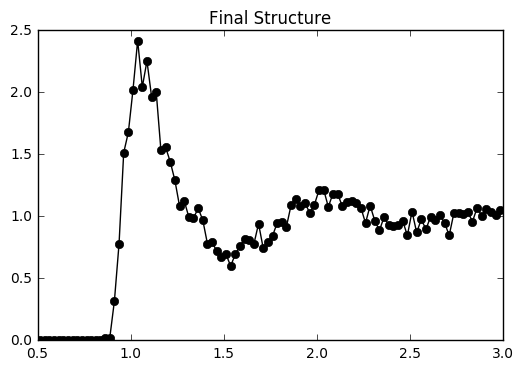

In [5]:
atombond.plot_energy_convergence(traj_filenm,istart=0)

In [6]:
atoms=traj[-1]
Vtot = atoms.get_volume()
print(Vtot)
dist_a=atoms.get_all_distances(mic=True)
dists_a = np.sort(dist_a)

610.940258945


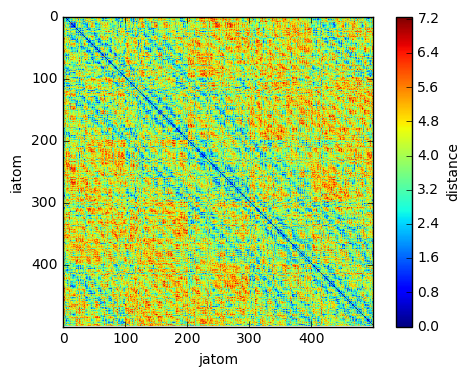

In [7]:
plt.imshow(dist_a)
cbar= plt.colorbar()
cbar.set_label('distance')
plt.xlabel('jatom')
plt.ylabel('iatom')

In [8]:
def coor_cutoff(dists_a,rcut=1.5):
    assert dists_a.ndim==1, 'dists_a must be a 1 dimensional array'

    # inputs distances and returns coordination number
    w_a = dists_a <= rcut
    coornum = np.sum(w_a)
    return coornum


In [9]:
def coor_econ(dists_a,TOL=1e-5,dosort=True,nexp=6):
    # assert len(dists_a.shape)
    assert dists_a.ndim==1, 'dists_a must be a 1 dimensional array'

    
    if dosort:
        dists_a = np.sort(dists_a)
    
    if dists_a[0]==0:
        dists_a = dists_a[1:]
        
    dnnavg = dists_a[0]
    
    # loops until distances stop changing
    while True:
        w_a = np.exp(1 - (dists_a / dnnavg)**nexp)
        dnnavg_next = np.sum(w_a * dists_a) / np.sum(w_a)
        if np.abs(dnnavg_next/dnnavg-1) < TOL:
            break
        dnnavg = dnnavg_next
    
    coornum = np.sum(w_a)
    return coornum
# coor_econ(dists_a) 

In [10]:
def coor_sann(idists_a):
    assert idists_a.ndim==1, 'dists_a must be a 1 dimensional array'

    N = idists_a.shape[0]
    rad1=idists_a[0]
    Nbond = 3
    # Nbond bc we want the 3rd index to be the 4th atom(the 1st atom that's not bonded)
    rnonbond = idists_a[Nbond]
    # sum over Nbond neighbors 
    rshell = np.sum(idists_a[:Nbond]/(Nbond-2))
    while rshell > rnonbond:
        Nbond += 1
        rshell = np.sum(idists_a[:Nbond]/(Nbond-2))
        rnonbond = idists_a[Nbond]
        
        
    w_a = (1-idists_a[:Nbond]/rshell)/(1-rad1/rshell)      
    coornum = np.sum(w_a)
    return coornum

# coor_sann(idists_a)

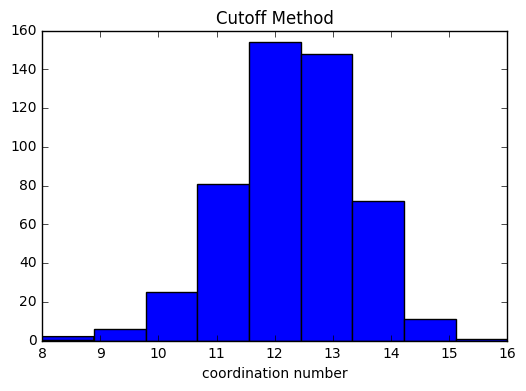

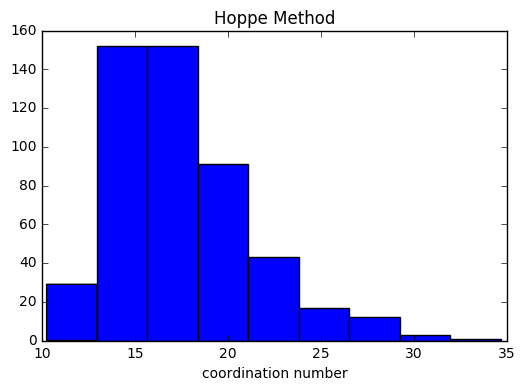

In [11]:
N = dist_a.shape[0]
cn_cutoff_a = np.zeros(N)
cn_econ_a = np.zeros(N)
for ind in np.arange(N):
    idist_a = dist_a[ind]
    icutoff = coor_cutoff(idist_a,rcut=1.5)
    iecon = coor_econ(idist_a,nexp=3)
    
    cn_cutoff_a[ind] = icutoff
    cn_econ_a[ind] = iecon
    

plt.hist(cn_cutoff_a,9)
plt.xlabel('coordination number')
plt.title('Cutoff Method')
plt.figure()

plt.hist(cn_econ_a,9)
plt.xlabel('coordination number')
plt.title('Hoppe Method')

(500, 499)
12
7.11802014739
6.49978300575


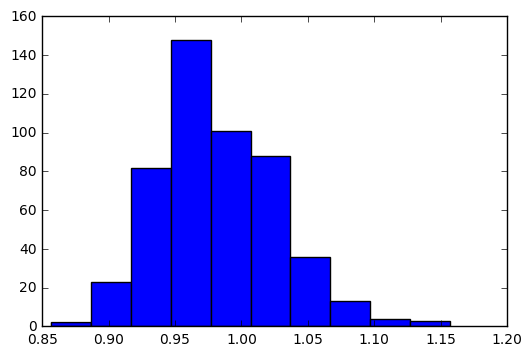

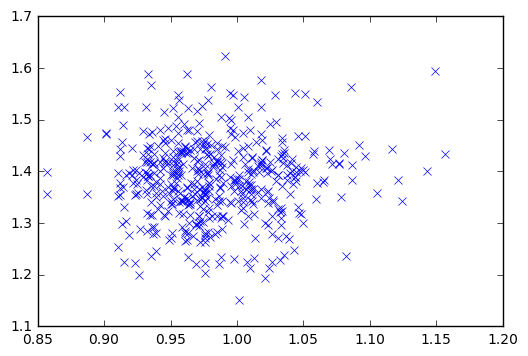

In [12]:
distalls_a=np.sort(dist_a,axis=1)[:,1:]
distalls_a[-1]
# plt.imshow(distalls_a)
plt.hist(distalls_a[:,0],10)
plt.figure()

nn_num=9

plt.plot((distalls_a[:,0]),(distalls_a[:,nn_num]), 'x')
print(distalls_a.shape)
iatom = 20
print(coor_cutoff(distalls_a[iatom]))
print(coor_econ(distalls_a[iatom]))
print(coor_sann(distalls_a[iatom]))

In [13]:
#################
def calc_rcut_global(pdf_a,sampdist_a):
    
    ind_max = np.argmax(pdf_a)
    ind_min= np.argmin(pdf_a[ind_max:]) + ind_max 
    rcut = sampdist_a[ind_min]
    
    return rcut

def calc_rcut_local(pdf_a,sampdist_a):
    
    ind_max = np.argmax(pdf_a)
    pdf_diff_a = np.diff(pdf_a[ind_max:])
    ind_min= np.where(pdf_diff_a> 0)[0][0] + ind_max
    
    
    #ind_min= np.argmin(pdf_a[ind_max:]) + ind_max 
    rcut = sampdist_a[ind_min]
    
    return rcut

In [14]:
Nx = 5
liq_at = atombond.get_lj_fcc_struc(super_a=[Nx,Nx,Nx],dNN=1.2,E_lj=1/40)
print(liq_at)

Atoms(symbols='X500', pbc=[True, True, True], cell=[8.48528137423857, 8.48528137423857, 8.48528137423857], positions=..., calculator=LennardJones(...))


In [15]:
Nat = liq_at.get_number_of_atoms()
Vat = liq_at.get_volume()
Lat = (Vat)**(1/3)
rhoat = Nat/Vat

In [16]:
def local_kernel(x_a):
    q_a = np.abs(x_a)
    kernel_a = np.zeros(q_a.shape)
    ind_outer = np.where(np.abs(q_a)<=2)
    kernel_a[ind_outer] = 1/6*(2-q_a[ind_outer])**3
    
    ind_inner = np.where(np.abs(q_a)<=1)
    kernel_a[ind_inner] = 1/6*( (2-q_a[ind_inner])**3 - 4*(1-q_a[ind_inner])**3 )

    return kernel_a

    
def approx_pdf_kde(dists_a,rhobar,bandwidth=0.25):
    if dists_a[0] == 0:
        dists_a = dists_a[1:]
    #FIX
    Nsamp = 1001
    pdf_approx_a = np.zeros(Nsamp)
    sampdist_a = np.linspace(0.001, Lat/2, Nsamp)
    for ind in np.arange(dists_a.size):
        #calculates the observed number of atoms per angstrom
        #if integrated, coordination number is given
        # dn_dr_a = (1/np.sqrt(2*np.pi)/bandwidth)*np.exp((-1/2)*(dists_a[ind]-sampdist_a)**2/(bandwidth**2))
        dn_dr_a = local_kernel( (dists_a[ind]-sampdist_a)/bandwidth )/ bandwidth
        assert dn_dr_a[0] == 0, 'bandwidth is too large for the closest neighboring atom'
        g_a = dn_dr_a/(4*np.pi*sampdist_a**2*rhobar)
        #print(g_a)
        
        # print(dn_dr_a[:20])
        pdf_approx_a += g_a
    
    return pdf_approx_a, sampdist_a


def approx_pdf_kde_adapt(dists_a,rhobar,num_neighbor=4,bandwidth_fac=1):
    if dists_a[0] == 0:
        dists_a = dists_a[1:]
    #FIX
    #bandwidth_a = np.array(idists_a.size)
    dist_diff_a = np.diff(dists_a)
    w_a=np.ones(num_neighbor-1)/(num_neighbor-1)
    avg_bandwidth_a=np.convolve(dist_diff_a,w_a, mode='valid')
    front_bandwidth_a=avg_bandwidth_a[0]*np.ones(num_neighbor/2)
    back_bandwidth_a =avg_bandwidth_a[-1]*np.ones(num_neighbor/2)
    bandwidth_a=bandwidth_fac*np.hstack((front_bandwidth_a,avg_bandwidth_a,back_bandwidth_a))*(dists_a/dists_a[0])**2
    print(bandwidth_a.shape)
    print(avg_bandwidth_a.shape)
    print(dists_a.shape)
    #print(bandwidth_a)
    
    dist_cutoff = Lat/2
    Nsamp = 1001
    pdf_approx_a = np.zeros(Nsamp)
    dn_dr_tot_a = np.zeros(Nsamp)
    sampdist_a = np.linspace(0.001, .8*dist_cutoff, Nsamp)
    
    #for ind in np.arange(np.round(idists_a.size*.8)):
    for ind in np.arange(idists_a.size):
        #calculates the observed number of atoms per angstrom
        #if integrated, coordination number is given
        ##dn_dr_a = (1/np.sqrt(2*np.pi)/bandwidth)*np.exp((-1/2)*(dists_a[ind]-sampdist_a)**2/(bandwidth**2))
        if dists_a[ind] > dist_cutoff:
            break
        ibandwidth= bandwidth_a[ind]
        dn_dr_a = local_kernel( (dists_a[ind]-sampdist_a)/ibandwidth )/ ibandwidth
        g_a = dn_dr_a/(4*np.pi*sampdist_a**2*rhobar)
        #print(g_a)
        
        # print(dn_dr_a[:20])
        pdf_approx_a += g_a
        dn_dr_tot_a +=dn_dr_a
    
    return pdf_approx_a, sampdist_a,dn_dr_tot_a


C:\Users\AJoiner\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\AJoiner\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


10.0

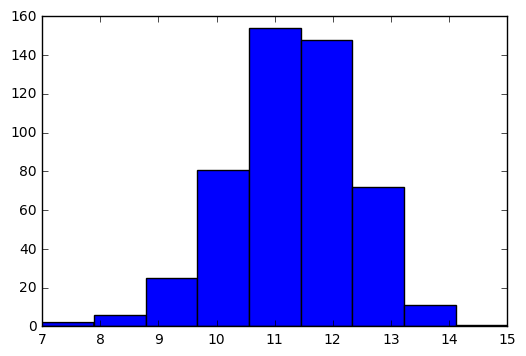

In [17]:
N = dist_a.shape[0]
cn_cutoff_a = np.zeros(N)
for ind in np.arange(N):
    idists_a = distalls_a[ind]
    icutoff = coor_cutoff(idists_a,rcut=1.5)
    
    cn_cutoff_a[ind] = icutoff
plt.hist(cn_cutoff_a,9)
cn_cutoff_a[8]
#print(cn_cutoff_a)

for CN in cn_cutoff_a: 
    #print(cn_cutoff_a[CN])
    nndist = dists_a[cn_cutoff_a[CN]][1:CN+1]
    avg_nndist = np.mean(dists_a[cn_cutoff_a[CN]][1:CN+1])
    #print(nndist)
#cn_cutoff_a[2]   
cn_cutoff_a[0]
#print(dists_a[cn_cutoff_a[11]][1:11])
#np.mean(dists_a[cn_cutoff_a[0]][1:11])
#print(avg_nndist)

In [18]:
# Correct but clunky version
avg_nndist_a = []
for ind in np.arange(dists_a.shape[0]):
    CN = cn_cutoff_a[ind]
    nndist = dists_a[ind][1:CN+1]
    assert len(nndist)==CN
    avg_nndist = np.mean(nndist)
    avg_nndist_a.append(avg_nndist)


print(np.median(avg_nndist_a))

1.20347758553


C:\Users\AJoiner\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [19]:
# Simplified version
avg_nndist_a = []
for iCN, idists in zip(cn_cutoff_a, dists_a):
    nndist = idists[1:iCN+1]
    assert len(nndist)==iCN
    avg_nndist = np.mean(nndist)
    avg_nndist_a.append(avg_nndist)
    
print(np.median(avg_nndist_a))
#print((avg_nndist_a))

1.20347758553


C:\Users\AJoiner\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


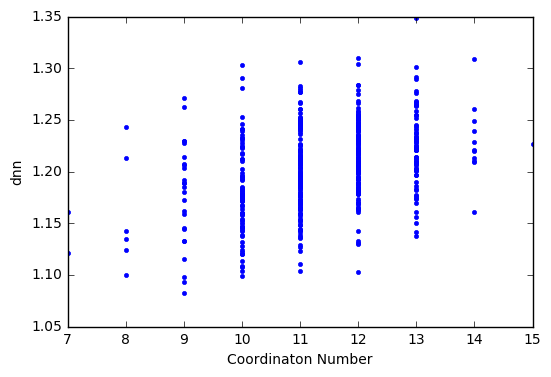

In [20]:
avg_nndist_a = np.array(avg_nndist_a)
cn_cutoff_a = np.array(cn_cutoff_a)
plt.plot(cn_cutoff_a, avg_nndist_a, '.')
plt.xlabel('Coordinaton Number')
plt.ylabel('dnn')

In [21]:
#i = 0
#avg_nndists_a= []#[[] for i in range(8)]#np.zeros(500)
nndist_stats_avg_a=[]
nndist_std_avg_a=[]
avg_nndist_len=[]
#std_nndist_a=[]
CN_a= [7, 8, 9, 10, 11, 12, 13, 14, 15]
for CN in CN_a:
    # Initialize list
    avg_nndists_a=[]
    
    # Loop through atoms
    for ind in np.arange(cn_cutoff_a.shape[0]):
        # Find if this atom's coor num equals target CN
        if cn_cutoff_a[ind]==CN:
            nndists_i=avg_nndist_a[ind]
            # add to group
            avg_nndists_a.append(nndists_i)
            
    
    # calculate summary statistics
    iavg_nndist=np.mean(avg_nndists_a)
    istd_nndist=np.std(avg_nndists_a)
    nndist_stats_avg_a.append(iavg_nndist)
    nndist_std_avg_a.append(istd_nndist)
    #print(iavg_nndist,istd_nndist)
    iavg_nndist_len=len(avg_nndists_a)
    avg_nndist_len.append(iavg_nndist_len)

nndist_stats_avg_a=np.array(nndist_stats_avg_a)
nndist_std_avg_a=np.array(nndist_std_avg_a)
avg_nndist_len=np.array(avg_nndist_len)
#print((avg_nndists_a))
#print(nndists_a)
print(nndist_stats_avg_a)
print(nndist_std_avg_a)
print(avg_nndist_len)

[ 1.14135704  1.1594299   1.17705147  1.17953005  1.19776708  1.21456035
  1.22200759  1.22892858  1.22672761]
[ 0.01980587  0.05082746  0.04947786  0.04285458  0.03760052  0.03396309
  0.03817665  0.0352349   0.        ]
[  2   6  25  81 154 148  72  11   1]


[1.1386796827424435, 1.1801801260216969]


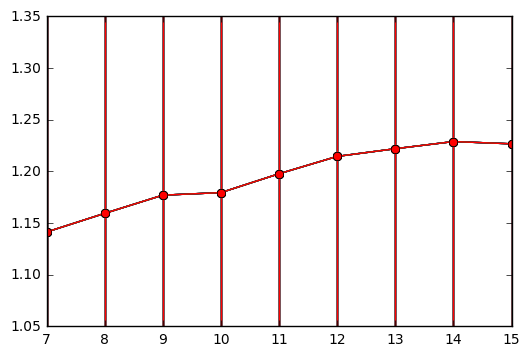

In [95]:
plt.plot(CN_a, nndist_stats_avg_a,'.')
plt.ylim(1.05,1.35)

for ind in np.arange(nndist_stats_avg_a.shape[0]):
    uppererror= nndist_stats_avg_a[ind]+nndist_std_avg_a[ind]/np.sqrt(avg_nndist_len[ind])
    lowererror= nndist_stats_avg_a[ind]-nndist_std_avg_a[ind]/np.sqrt(avg_nndist_len[ind])
    #asymmetric_error=[lowererror, uppererror]
    plt.errorbar(CN_a, nndist_stats_avg_a,yerr=np.array(lowererror ,uppererror), fmt='-o')
    #print(error)


upper_error=(nndist_stats_avg_a[1]+nndist_std_avg_a[1]/np.sqrt(6))
lower_error=(nndist_stats_avg_a[1]-nndist_std_avg_a[1]/np.sqrt(6))
asymmetric_error=[lower_error, upper_error]
#plt.errorbar(CN_a,nndist_stats_avg_a,yerr=np.array(asymmetric_error)
#nndist_stats_avg_a[8]+nndist_std_avg_a[8]/np.sqrt(avg_nndist_len)
print(asymmetric_error)

[ 0.01124868  1.07041558]


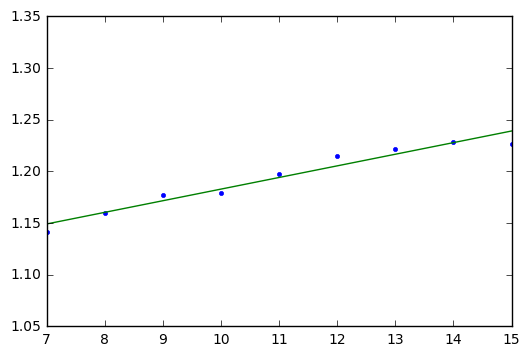

In [147]:
plt.plot(CN_a, nndist_stats_avg_a,'.')
plt.ylim(1.05,1.35)

coef=np.polyfit(CN_a, nndist_stats_avg_a,1)
ymod=np.polyval(coef,CN_a)
print(coef)

plt.plot(np.unique(CN_a), np.poly1d(np.polyfit(CN_a, nndist_stats_avg_a, 1))(np.unique(CN_a)))

In [120]:
import bondgeom 

In [127]:
bondgeom.get_poly_geom()

{'bondang': array([ 180.        ,  119.99708892,  109.47122063,   91.80054054,
          90.01081875,   78.87572049,   74.63003766,   71.28671748,
          67.0890034 ,   62.8772511 ,   63.43495074,   58.79444678,
          56.98357302,   54.89497119,   53.37901534]),
 'cn': array(dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]), dtype=object),
 'nndist': array([ 2.        ,  1.7320254 ,  1.63299316,  1.43625916,  1.41434707,
         1.27048197,  1.21239379,  1.16547624,  1.105169  ,  1.04316986,
         1.05146225,  0.98172307,  0.95406555,  0.92187086,  0.89831078]),
 'nnpairnum': array([  1.        ,   2.999868  ,   5.99999993,   6.9101067 ,
         12.00273548,  12.03556491,  14.83526182,  18.35516023,
         19.7777804 ,  20.97161921,  29.99999876,  27.82761362,
         30.52603174,  33.07485341,  36.23008564]),
 'pos': {2: array([[ 0.,  0.,  1.],
         [ 0.,  0., -1.]]), 3: array([[ 0.   ,  1.   ,  0.   ],
         [ 0.866, -0.5  ,  0.   ],
         [-0.8

In [135]:
r_a, g_avg_a = atombond.calc_avg_pdf(traj_filenm, istart=50,dist_range = [0.5,3.0],nbins=100)
bondgeom.calc_pdf_geom(rhoat, r_a, g_avg_a)

{'cn': 11.791993248494018,
 'cneff': 6.1718675150577225,
 'fpack_nnavg': 0.77059296688251744,
 'pdf_a': array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   3.70386534e-04,   5.93686777e-03,
          5.93696013e-02,   2.77686114e-01,   6.94832027e-01,
          1.26027187e+00,   1.79439792e+00,   2.18069945e+00,
          2.33987536e+00,   2.26251556e+00,   2.19879410e+00,
          2.04545950e+00,   1.85474151e+00,   1.68746002e+00,
          1.53996481e+00,   1.40572437e+00,   1.28690248e+00,
          1.18075160e+00,   1.08884756e+00,   1.01372997e+00,
          9.52564676e-01,   8.97683797e-01,   8.40436090e-01,
          7.93804900e-01,   7.69368720e-01,   7.45072466e-01,
          7.35111941e-01,   7.36829923e-01,   7.40502913e-01,
          7.34839339e-01,   7